In [1]:
#echo 1 | sudo tee /proc/sys/vm/overcommit_memory
#export LD_LIBRARY_PATH=${LD_LIBRARY_PATH}:/usr/local/cuda/lib64

import numpy as np

Path = "RBG32Bit"

#Load Training, validation and test images
train_images = np.load(Path + "/train_images.npy")
val_images = np.load(Path + "/val_images.npy")
test_images = np.load(Path + "/test_images.npy")

#Load Training, validation and test labels
train_lab = np.load(Path + "/train_lab.npy")
val_lab = np.load(Path + "/val_lab.npy")
test_lab = np.load(Path + "/test_lab.npy")


Epoch 1/4
1627/1627 [==============================] - 19s 12ms/step - loss: 1.7748 - acc: 0.3386 - val_loss: 1.7515 - val_acc: 0.3424
Epoch 2/4
1627/1627 [==============================] - 17s 11ms/step - loss: 1.6457 - acc: 0.3703 - val_loss: 1.7780 - val_acc: 0.3524
Epoch 3/4
1627/1627 [==============================] - 17s 11ms/step - loss: 1.6090 - acc: 0.3845 - val_loss: 1.8750 - val_acc: 0.3568
Epoch 4/4
1627/1627 [==============================] - 16s 10ms/step - loss: 1.5783 - acc: 0.3938 - val_loss: 1.9083 - val_acc: 0.3650
0 input_15
1 conv1_pad
2 conv1
3 conv1_bn
4 conv1_relu
5 conv_dw_1
6 conv_dw_1_bn
7 conv_dw_1_relu
8 conv_pw_1
9 conv_pw_1_bn
10 conv_pw_1_relu
11 conv_pad_2
12 conv_dw_2
13 conv_dw_2_bn
14 conv_dw_2_relu
15 conv_pw_2
16 conv_pw_2_bn
17 conv_pw_2_relu
18 conv_dw_3
19 conv_dw_3_bn
20 conv_dw_3_relu
21 conv_pw_3
22 conv_pw_3_bn
23 conv_pw_3_relu
24 conv_pad_4
25 conv_dw_4
26 conv_dw_4_bn
27 conv_dw_4_relu
28 conv_pw_4
29 conv_pw_4_bn
30 conv_pw_4_relu
31 con

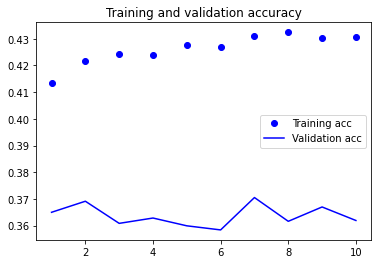

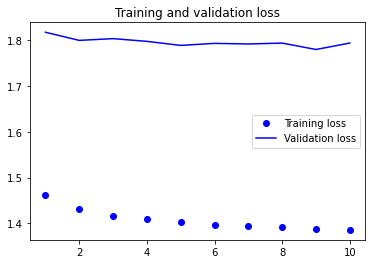

In [16]:
from keras import layers
from keras import optimizers
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, RMSprop
#from keras.models import load_model
import os
import matplotlib.pyplot as plt


os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"


from keras.applications import MobileNet


base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(10, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.001, momentum=0.9), metrics=['acc'])


history1 = model.fit(train_images, train_lab, epochs=4, batch_size = 32, validation_data = (val_images, val_lab), shuffle = True)

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:86]:
   layer.trainable = False
for layer in model.layers[86:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['acc'])

history = model.fit(train_images, train_lab, epochs=10, batch_size = 32, validation_data = (val_images, val_lab), shuffle = True)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()